In [12]:
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import decimate

from audio import AudioDataset, AudioFile

test = AudioDataset('../data/raw/nsynth-test')
train = AudioDataset('../data/raw/nsynth-train')
guitar = AudioFile(*test.get_filepath('guitar_acoustic', 6))
piano = AudioFile(*train.get_filepath('keyboard_acoustic', 27))

In [13]:
def cut_min_idx(spectrogram_log):
    min_logidx = np.where(spectrogram_log == 1)
    min_logidx = min_logidx[1].max() if min_logidx[1].shape[0] > 0 else 0
    max_logidx = np.where(spectrogram_log == 2)
    max_logidx = max_logidx[1].min() if max_logidx[1].shape[0] > 0 else -1
    spectrogram_log = spectrogram_log[:, min_logidx:max_logidx]
    return spectrogram_log

In [14]:
def scipy_downsample(audiofile, resolution, scaling):
    # Downsample
    downsampled = audiofile.spectrogram_log.copy()
    for i in range(scaling[0]):
        downsampled = decimate(downsampled, scaling[1])
    # Convert
    audiofile.spectrogram_log = downsampled.reshape(1, -1)
    audiofile.set_log_resolution(resolution//(scaling[1]**scaling[0]))

In [15]:
def pillow_downsample(audiofile, resolution, size, resample):
    # Downsample
    original_size = audiofile.spectrogram_log.shape[1]
    downsampled = audiofile.spectrogram_log.copy()
    shift = downsampled.min()
    downsampled -= shift
    scale = 255 / downsampled.max()
    downsampled *= scale
    downsampled[downsampled>255] = 255.
    img = Image.fromarray(downsampled)
    img = img.convert("L")
    img = img.resize(size, resample)
    # Convert
    audiofile.spectrogram_log = np.array(img.getdata()).reshape(1, -1).astype(float)
    audiofile.spectrogram_log /= scale
    audiofile.spectrogram_log += shift
    audiofile.set_log_resolution(int(resolution * (size[0]/original_size)))

In [16]:
def log_xscale(audiofile, spectrogram, ax, min_freq):
    max_freq = audiofile.nyquist
    min_idx = audiofile._log_to_logidx(audiofile._freq_to_log(min_freq))
    x_step = audiofile.fundamental_freq
    first_fundamental = audiofile.fundamental_freq * (1 + (min_freq//audiofile.fundamental_freq))
    nth_fundamental =  min(max_freq, first_fundamental+(x_step*5))
    xtick_freqs = range(first_fundamental, nth_fundamental+1, x_step)
    ax.set_xticks([audiofile._log_to_logidx(audiofile._freq_to_log(x)) - min_idx
                   for x in xtick_freqs])
    ax.set_xticklabels(xtick_freqs)

In [27]:
def plot_spectrogram(audiofile, spectrogram, ax, min_freq=1, label=''):
    ax.plot(spectrogram[0], label=label)
    log_xscale(audiofile, spectrogram, ax, min_freq)
    ax.grid(linewidth=2)
    ax.set_ylim(-7, 0.5)
    ax.legend()
    print(spectrogram[0].shape)

In [28]:
def compare_downscaling(audiofile, min_freq=10, max_freq=-1, resolution=16508,
                        scaling=(1, 10), resample=3):

    # Load audio and create spectrogram
    audiofile.trim_audio(start=0.5, end=3.5)
    audiofile.audio_to_spectrogram(spec_thresh=10)
    min_idx = audiofile._freq_to_idx(min_freq)
    max_idx = audiofile._freq_to_idx(max_freq)
    audiofile.spectrogram[:, :min_idx] = 1
    audiofile.spectrogram[:, max_idx:] = 2
    audiofile.nyquist = max_freq
    
    # Plots
    fig, axes = plt.subplots(3, 1, figsize=(30, 30))
    # SCIPY anti-alias downsampling
    audiofile.spectrogram_to_log(audiofile.spectrogram, resolution=resolution)
    audiofile.spectrogram_log = cut_min_idx(audiofile.spectrogram_log)
    scipy_downsample(audiofile, resolution, scaling=scaling)
    plot_spectrogram(audiofile, audiofile.spectrogram_log, axes[0], min_freq)
    # PILLOW anti-alias resizing
    size = audiofile.spectrogram_log.shape[1]
    audiofile.spectrogram_to_log(audiofile.spectrogram, resolution=resolution)
    audiofile.spectrogram_log = cut_min_idx(audiofile.spectrogram_log)
    pillow_downsample(audiofile, resolution, (size, 1), resample=0)
    plot_spectrogram(audiofile, audiofile.spectrogram_log, axes[1], min_freq, '0')
    # PILLOW anti-alias resizing 2
    audiofile.spectrogram_to_log(audiofile.spectrogram, resolution=resolution)
    audiofile.spectrogram_log = cut_min_idx(audiofile.spectrogram_log)
    pillow_downsample(audiofile, resolution, (size, 1), resample=3)
    plot_spectrogram(audiofile, audiofile.spectrogram_log, axes[1], min_freq, '3')
    # Max resolution
    audiofile.spectrogram_to_log(audiofile.spectrogram, resolution=resolution)
    audiofile.spectrogram_log = cut_min_idx(audiofile.spectrogram_log)
    plot_spectrogram(audiofile, audiofile.spectrogram_log, axes[2], min_freq)

## Piano

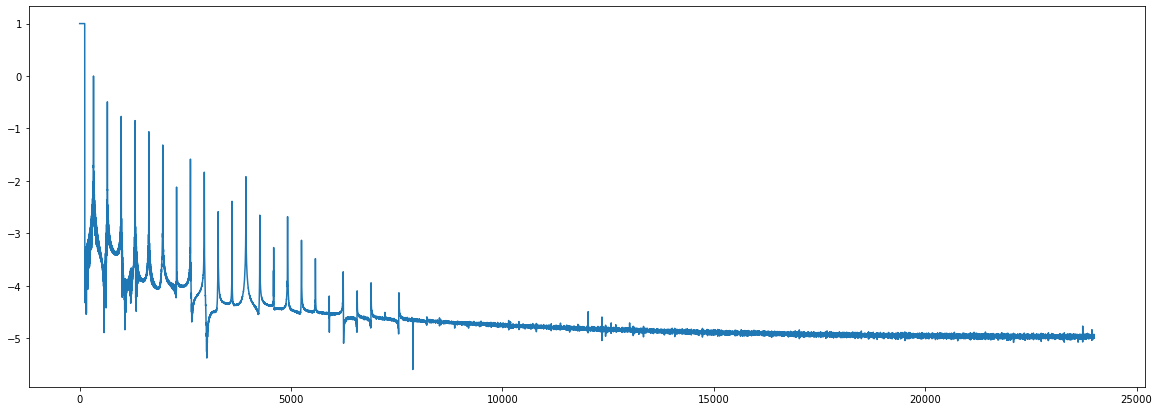

In [37]:
plt.figure(figsize=(20, 7))
plt.plot(guitar.spectrogram[0])

No handles with labels found to put in legend.


(3563,)
(3563,)


No handles with labels found to put in legend.


(3563,)
(128257,)


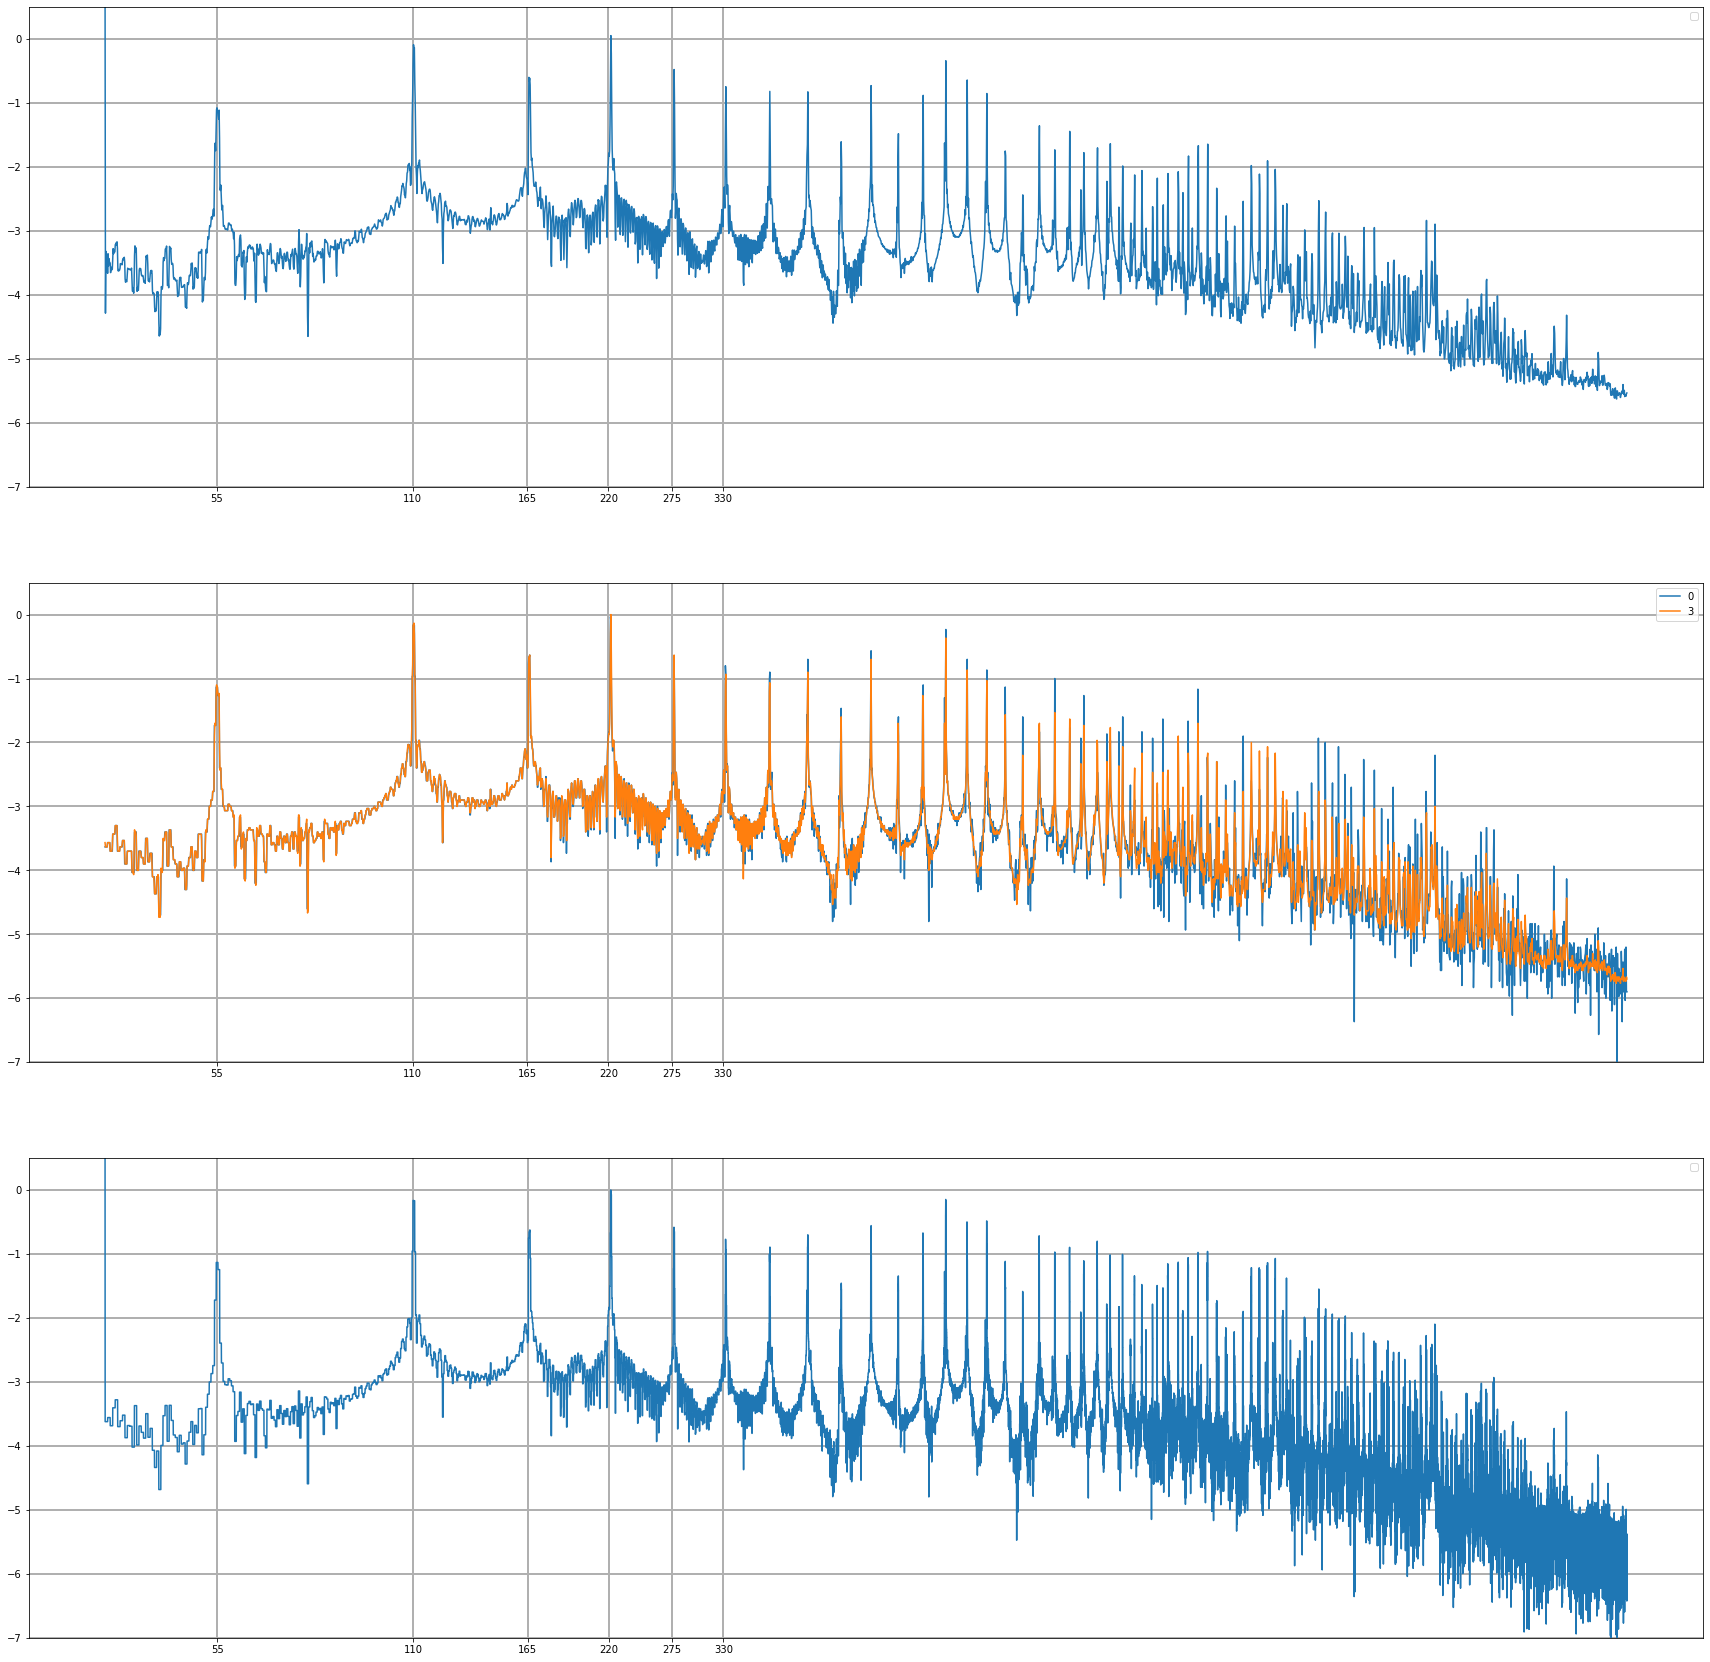

In [31]:
compare_downscaling(piano, min_freq=37, max_freq=8000, scaling=(2, 6), resample=0)

## Guitar

No handles with labels found to put in legend.


(2580,)
(2580,)


No handles with labels found to put in legend.


(2580,)
(126384,)


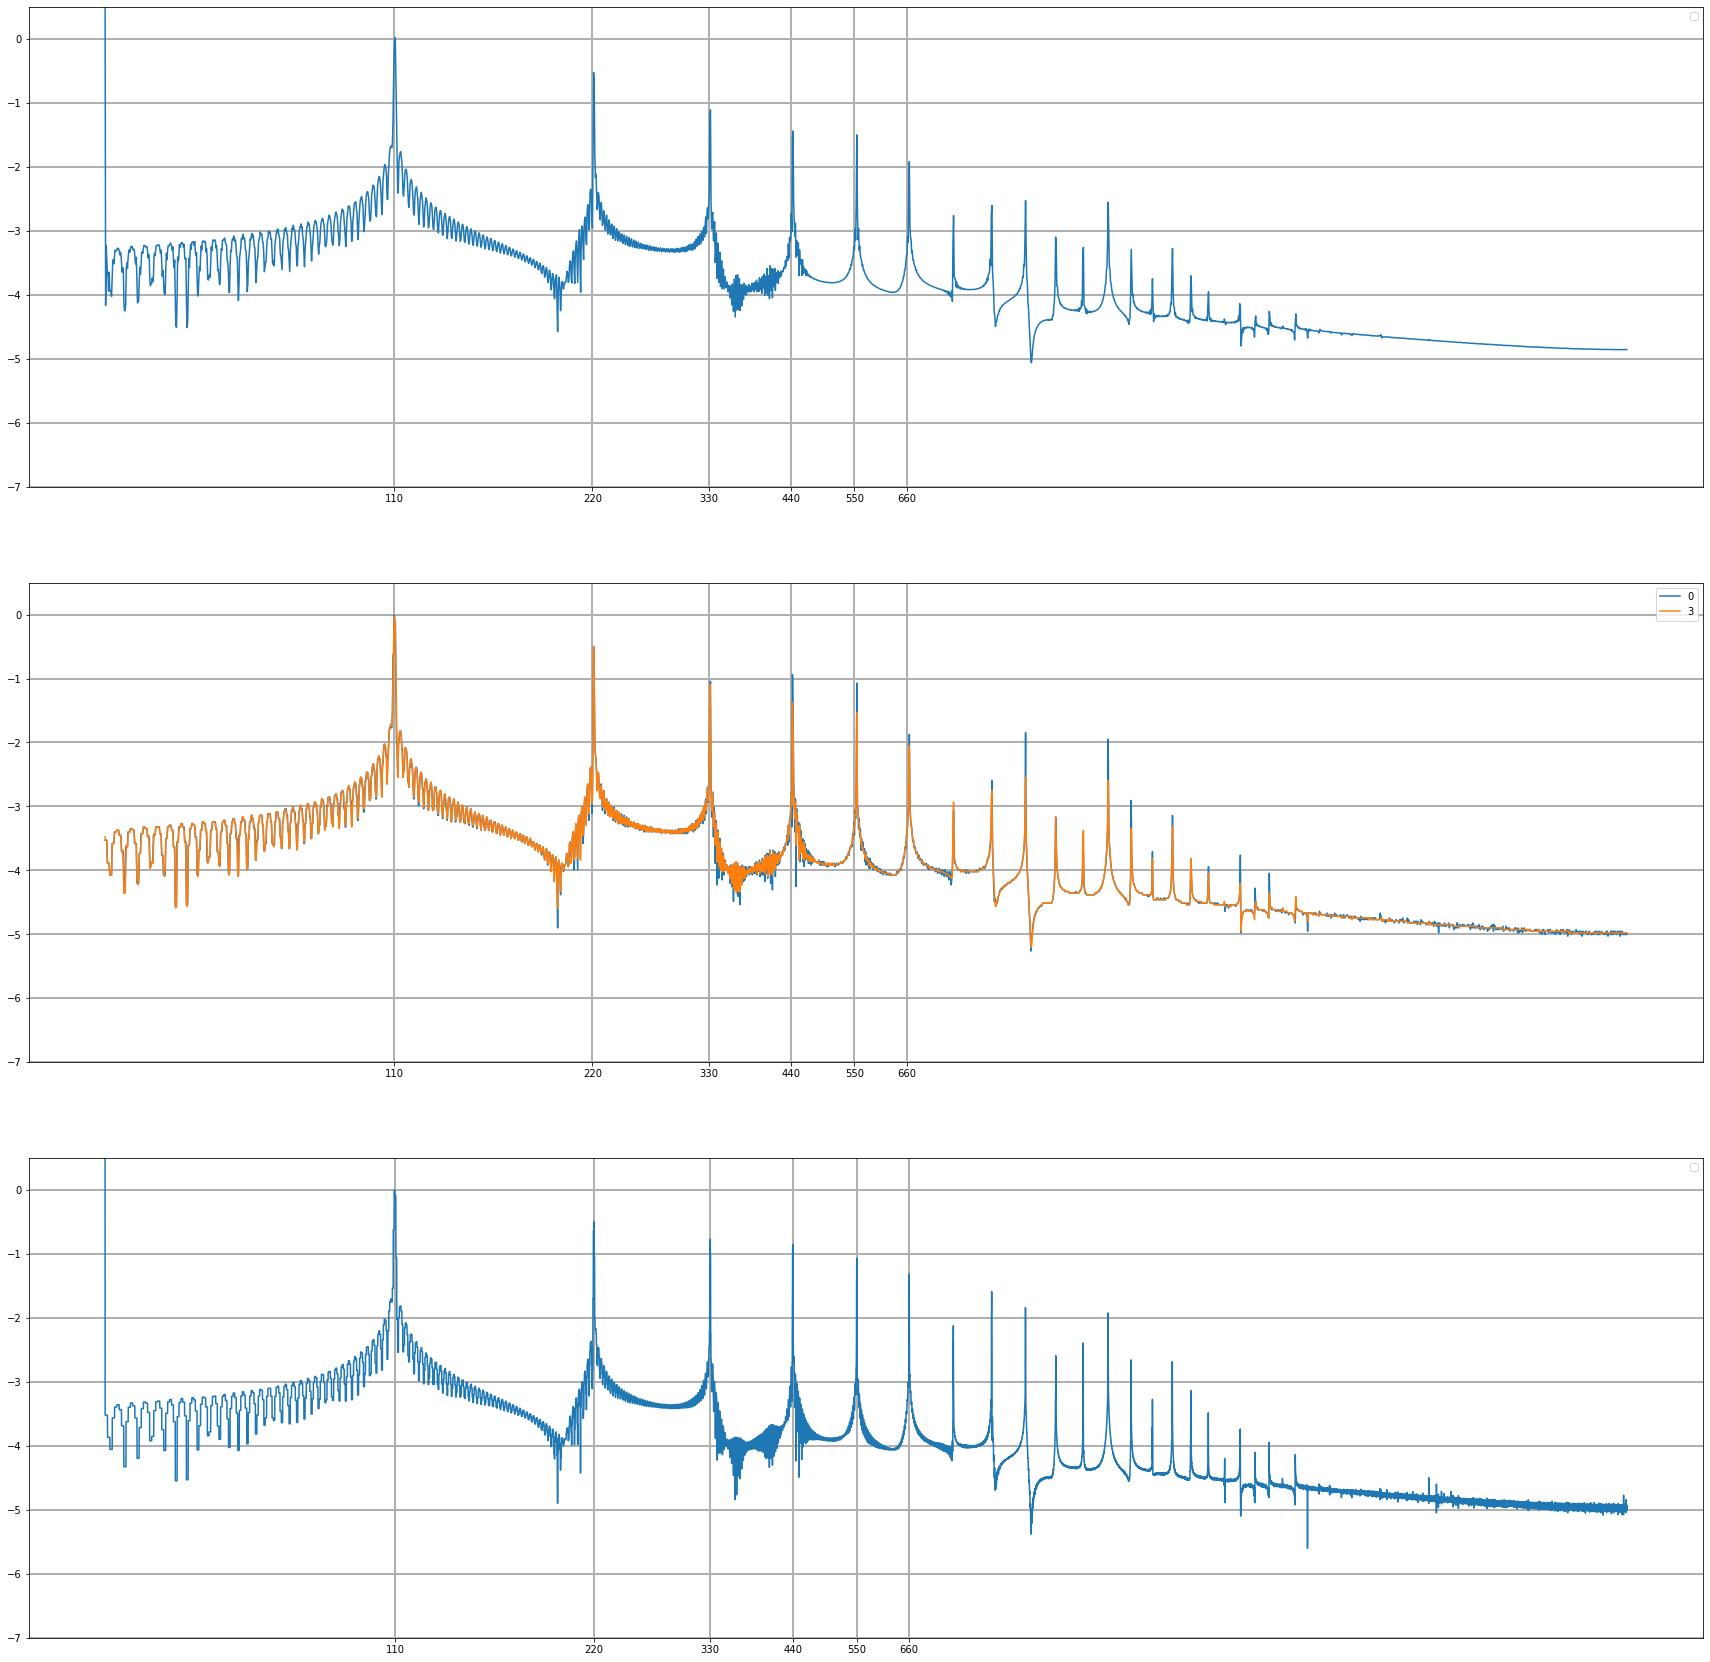

In [30]:
compare_downscaling(guitar, min_freq=40, max_freq=8000, scaling=(2, 7))